In [17]:
from IPython.display import Image
from IPython.core.display import HTML 
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as colors
!conda install -c conda-forge geopy --yes

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



# Exploration of Tokyo's Neighbourhoods Using K-Means Clustering

## 1.Introduction

Informally, the city of Tokyo refers to the 23 special wards within the greater Tokyo Prefecture. It's the economic and cultural capital of Japan with a population of 9.4 million: Approximately 7.4% of Japan's total population[1]. At daytime, this number increases further as commuters from satellite areas come to work.

The sheer size of Tokyo's polulation provides ample opportunies for small businesses. There's a large demand for the catering sector as millions of office workers shop for lunch and dine at restaurants day-in day-out. However, identifying the best place to open a new restaurant may not be a straightforward task, as the city is non-homogeneous. Here, we use data science methods to analyze the 23 wards of Tokyo and to shed insights into their characteristics. We will also use K-Means clustering algorithm to group these wards into clusters. 

The main audiences of this article are:
1. Business personnel who are considering to open a restaurant in Tokyo, who wishes to utilise data science to aid decision in selecting the best locations.
2. Tourists who are travelling Tokyo and looking for popular places to dine.
3. Fellow data scientsits who are interested in machine learning and its real-world applications.


In [18]:
Image(url="https://upload.wikimedia.org/wikipedia/commons/1/16/Tokyo_special_wards_map.svg")

## 2.Data

### 2.1.Scraping from Wikipedia

We used the 'Special Wards of Tokyo' page from Wikipedia to create our data-frame table[1]. We obtained the names and the population density for each of Tokyo's 23 wards.
After some manipulation, a _pandas_ dataframe was generated:

In [19]:
df = pd.read_csv('Tokyo.csv')
df.columns = ['Ward','Kanji','Population Density']
df.head()

,Ward,Kanji,Population Density
0,Chiyoda,千代田区,"5,100"
1,Chuo,中央区,"14,460"
2,Minato,港区,"12,180"
3,Shinjuku,新宿区,"18,620"
4,Bunkyo,文京区,"19,790"


### 2.2.Obtaining the coordinates of each ward using _Geopy_

The coordinates for Tokyo's wards are not readily available in tabular form. Therefore, we sought to obtain them using third-party methods. Given that Google's API is no longer free to use, we chose Python's GeoPy geocoding library as our method.

For each iteration of the for-loop, we searched for "(Ward name), Tokyo" using GeoPy and obtained the latitudinal and longitudinal information. We then added these information to the _pandas_ dataframe. The search was carried out in Japanese for better accuracy and to prevent translation errors.

In [20]:
from geopy.geocoders import Nominatim
longitudes = []
latitudes = []
for ward in df['Kanji']:
    address = ward + ', 東京都'
    geolocator = Nominatim(user_agent="tk_explorer")
    location = geolocator.geocode(address)
    longitudes.append(location.longitude)
    latitudes.append(location.latitude)    
df['Latitude'] = latitudes    
df['Longitude'] = longitudes 
df.head()    

,Ward,Kanji,Population Density,Latitude,Longitude
0,Chiyoda,千代田区,"5,100",35.693810,139.753216
1,Chuo,中央区,"14,460",35.666255,139.775565
2,Minato,港区,"12,180",35.097771,136.850107
3,Shinjuku,新宿区,"18,620",35.715847,139.684266
4,Bunkyo,文京区,"19,790",35.711291,139.753231


We inspected the accuratcy of these coordinates through plotting a _folium_ map. _Folium_ is a Python library capable of plotting interactive maps using coordinate data.

In [21]:
import folium
map_tk = folium.Map(location=[35.7, 139.8], zoom_start=11)
for lat, lng, label in zip(df['Latitude'], df['Longitude'], df['Ward']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng], radius=5, popup=label, color='blue', fill=True, fill_color='#3186cc', fill_opacity=0.7, parse_html=False).add_to(map_tk)      
map_tk

Through visual inspection, the markers of __Shinjuku, Bunkyo, Arakawa, Edokawa__ were not placed at their centre. Furthermore, __Minato__ was mistaken as the Minato ward in Nagoya. We corrected these coordinates manually.

In [22]:
df.loc[df['Ward'] == 'Shinjuku','Latitude'], df.loc[df['Ward'] == 'Shinjuku','Longitude'] = 35.7013,139.7097 
df.loc[df['Ward'] == 'Bunkyo','Latitude'], df.loc[df['Ward'] == 'Bunkyo','Longitude'] = 35.7190, 139.7506
df.loc[df['Ward'] == 'Arakawa','Latitude'], df.loc[df['Ward'] == 'Arakawa','Longitude'] = 35.7390, 139.7816
df.loc[df['Ward'] == 'Edogawa','Latitude'], df.loc[df['Ward'] == 'Edogawa','Longitude'] = 35.6974, 139.8820
df.loc[df['Ward'] == 'Minato','Latitude'], df.loc[df['Ward'] == 'Minato','Longitude'] = 35.6511, 139.7398

In [23]:
map_tk = folium.Map(location=[35.7, 139.8], zoom_start=11)
for lat, lng, label in zip(df['Latitude'], df['Longitude'], df['Ward']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng], radius=5, popup=label, color='blue', fill=True, fill_color='#3186cc', fill_opacity=0.7, parse_html=False).add_to(map_tk)      
map_tk

### 2.4.Using Foursquare location data

Foursquare provides comprehensive location data and it poweres tech giants such as Twitter, Apple and Tencent. Foursquare has an open API, which was used here to retireve information about the popular spots around Tokyo's 23 wards. The call returns a JSON file, we then transformed it into a dataframe. 200 popular spots for each major districts within a radius of 1 km were chosen (as the location markers are seperated by at least 2km). The verson used was 20200816.

In [24]:
CLIENT_ID = 'MKIEKSLENSPZOWYTZOYU5F513YX1I4XX14CSOEDHPOVRBLMG' # your Foursquare ID
CLIENT_SECRET = '-' # your Foursquare Secret
VERSION = '20200815' # Foursquare API version

In [56]:
import requests
def getNearbyVenues(names, latitudes, longitudes, radius=1000, LIMIT=200):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat,  lng, radius, LIMIT)
        results = requests.get(url).json()["response"]['groups'][0]['items']
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Ward', 
                  'Ward Latitude', 
                  'Ward Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [57]:
tk_venues = getNearbyVenues(names=df['Ward'], latitudes=df['Latitude'], longitudes=df['Longitude'])

Chiyoda
Chuo
Minato
Shinjuku
Bunkyo
Taito
Sumida
Koto
Shinagawa
Meguro
Ota
Setagaya
Shibuya
Nakano
Suginami
Toshima
Kita
Arakawa
Itabashi
Nerima
Adachi
Katsushika
Edogawa


In [58]:
tk_venues.groupby('Ward').count()
print('There are {} uniques categories.'.format(len(tk_venues['Venue Category'].unique())))

There are 241 uniques categories.


## 3.Methodology 

### 3.1.One Hot Encoding

Prior to analysis using machine learning, the dataframe needs to be properly formated. Here, we used _pandas_ one hot encoding to convert our dataframe. The columns were then grouped by wards and transposed. The top 10 most common venue for 5 of the wards were shown below:

In [130]:
onehot = pd.get_dummies(tk_venues[['Venue Category']], prefix="", prefix_sep="")
onehot['Ward'] = tk_venues['Ward'] 
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]
tk_grouped = onehot.groupby('Ward').mean().reset_index()

In [131]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
columns = ['Ward']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Ward'] = tk_grouped['Ward']

for ind in np.arange(tk_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(tk_grouped.iloc[ind, :], num_top_venues)
neighborhoods_venues_sorted.head()

,Ward,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adachi,Convenience Store,Ramen Restaurant,Park,Discount Store,Supermarket,Fast Food Restaurant,Japanese Family Restaurant,Japanese Restaurant,Restaurant,Chinese Restaurant
1,Arakawa,Convenience Store,Grocery Store,Ramen Restaurant,Discount Store,Japanese Restaurant,Sake Bar,BBQ Joint,Shopping Mall,Café,Sushi Restaurant
2,Bunkyo,Convenience Store,BBQ Joint,Café,Italian Restaurant,Ramen Restaurant,Supermarket,Chinese Restaurant,Grocery Store,Coffee Shop,Discount Store
3,Chiyoda,Café,Ramen Restaurant,Japanese Curry Restaurant,Chinese Restaurant,Bookstore,Tempura Restaurant,Coffee Shop,Yoshoku Restaurant,Steakhouse,Szechuan Restaurant
4,Chuo,Sushi Restaurant,Japanese Restaurant,Monjayaki Restaurant,Italian Restaurant,Soba Restaurant,Seafood Restaurant,Bakery,Kaiseki Restaurant,Coffee Shop,Donburi Restaurant


### 3.2.K-Means clustering

K-Means clustering is a very common clustering algorithm in data science. It's an iterative approach where items are grouped into k number of clusters according to the distance to the centroids. Here, we selected random positions for initial centroid positions. One feature of the K-Means algorithm is that the initial positions of the centroids can influence the final outcome and does not guarantee the optimal solution, different runs with different starting positions can result in different outcomes.

In [132]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [133]:
tk_grouped.head()

,Ward,ATM,Accessories Store,African Restaurant,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Used Bookstore,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wagashi Place,Whisky Bar,Wine Bar,Wine Shop,Yakitori Restaurant,Yoshoku Restaurant
0,Adachi,0.013333,0.0,0.0,0.0,0.013333,0.0,0.00,0.0,0.0,...,0.00,0.0,0.013333,0.00,0.0,0.0,0.0,0.0,0.0,0.00
1,Arakawa,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,...,0.00,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.00
2,Bunkyo,0.020000,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,...,0.00,0.0,0.000000,0.01,0.0,0.0,0.0,0.0,0.0,0.00
3,Chiyoda,0.000000,0.0,0.0,0.0,0.000000,0.0,0.02,0.0,0.0,...,0.02,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.03
4,Chuo,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,...,0.00,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.02


The dataframe was converted to a _numpy_ array and standardised using _sklearn_'s standard scaler.

In [134]:
X = tk_grouped.drop('Ward', 1).values
X = StandardScaler().fit_transform(X)
X

array([[ 2.08419846, -0.21320072, -0.21320072, ..., -0.21320072,
        -0.60955692, -0.69762339],
       [-0.3793509 , -0.21320072, -0.21320072, ..., -0.21320072,
        -0.60955692, -0.69762339],
       [ 3.31597313, -0.21320072, -0.21320072, ..., -0.21320072,
        -0.60955692, -0.69762339],
       ...,
       [-0.3793509 , -0.21320072, -0.21320072, ..., -0.21320072,
         0.94819965,  0.9574831 ],
       [-0.3793509 , -0.21320072, -0.21320072, ..., -0.21320072,
        -0.60955692,  1.78503634],
       [-0.3793509 , -0.21320072, -0.21320072, ..., -0.21320072,
         0.94819965,  2.61258958]])

In [135]:
k = 5
kmeans = KMeans(init='k-means++', n_clusters=k, n_init=12)
kmeans.fit(X)
kmeans.labels_

array([3, 0, 3, 3, 3, 0, 3, 0, 3, 3, 0, 4, 3, 3, 3, 3, 2, 3, 1, 3, 3, 3,
       3], dtype=int32)

Silohuette Score measures how similar an object is to its own cluster compared to other clusters. The value can take any value between 1 and -1. An object well matched to its own cluster would have a score near 1, whereas an object poorly matched to its cluster would score -1. Below shows a plot of silouette score for different numbers of k:

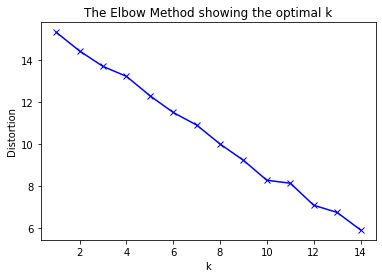

In [136]:
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

plt.plot()
colors = ['b', 'g', 'r']
markers = ['o', 'v', 's']

# k means determine k
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(init='k-means++', n_clusters=k, n_init=5).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

According to the graph there wasn't a clear elbow point. Thus, we chose k = 5 as it gives enough variety without being too large.

In [137]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)



## 4.Result

In [138]:
tk_merged =df.join(neighborhoods_venues_sorted.set_index('Ward'), on='Ward')
tk_merged.head()

,Ward,Kanji,Population Density,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Chiyoda,千代田区,"5,100",35.693810,139.753216,3,Café,Ramen Restaurant,Japanese Curry Restaurant,Chinese Restaurant,Bookstore,Tempura Restaurant,Coffee Shop,Yoshoku Restaurant,Steakhouse,Szechuan Restaurant
1,Chuo,中央区,"14,460",35.666255,139.775565,3,Sushi Restaurant,Japanese Restaurant,Monjayaki Restaurant,Italian Restaurant,Soba Restaurant,Seafood Restaurant,Bakery,Kaiseki Restaurant,Coffee Shop,Donburi Restaurant
2,Minato,港区,"12,180",35.651100,139.739800,4,Japanese Restaurant,Sake Bar,Ramen Restaurant,Chinese Restaurant,Soba Restaurant,Italian Restaurant,Pizza Place,Café,BBQ Joint,Grocery Store
3,Shinjuku,新宿区,"18,620",35.701300,139.709700,1,Korean Restaurant,BBQ Joint,Sake Bar,Japanese Restaurant,Bar,Rock Club,Ramen Restaurant,Chinese Restaurant,Soba Restaurant,Hotel
4,Bunkyo,文京区,"19,790",35.719000,139.750600,3,Convenience Store,BBQ Joint,Café,Italian Restaurant,Ramen Restaurant,Supermarket,Chinese Restaurant,Grocery Store,Coffee Shop,Discount Store


In [139]:
import matplotlib.cm as cm
import matplotlib.colors as colors
map_clusters = folium.Map(location=[35.7, 139.8], tiles='cartodbpositron', zoom_start=11)
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(10)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = ['red', 'blue','orange','green','yellow']

markers_colors = []
for lat, lon, poi, cluster in zip(tk_merged['Latitude'], tk_merged['Longitude'], tk_merged['Ward'], tk_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker([lat, lon], radius=15, popup=label, color=rainbow[cluster-1], fill=True, fill_color=rainbow[cluster-1], fill_opacity=0.3).add_to(map_clusters)
map_clusters

## 5.Discussion

### Cluster 1

In [140]:
tk_merged.loc[tk_merged['Cluster Labels'] == 0, tk_merged.columns[[0] + list(range(5, tk_merged.shape[1]))]]

,Ward,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Meguro,0,Convenience Store,Coffee Shop,Café,Japanese Restaurant,Grocery Store,Park,Ramen Restaurant,Chinese Restaurant,Sake Bar,Dessert Shop
17,Arakawa,0,Convenience Store,Grocery Store,Ramen Restaurant,Discount Store,Japanese Restaurant,Sake Bar,BBQ Joint,Shopping Mall,Café,Sushi Restaurant
21,Katsushika,0,Convenience Store,Train Station,Grocery Store,Ramen Restaurant,Donburi Restaurant,Japanese Restaurant,Supermarket,Intersection,Discount Store,Coffee Shop
22,Edogawa,0,Convenience Store,Intersection,Japanese Restaurant,BBQ Joint,Bus Stop,Grocery Store,Park,Ramen Restaurant,Electronics Store,Butcher


### Cluster 2

In [141]:
tk_merged.loc[tk_merged['Cluster Labels'] == 1, tk_merged.columns[[0] + list(range(5, tk_merged.shape[1]))]]

,Ward,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Shinjuku,1,Korean Restaurant,BBQ Joint,Sake Bar,Japanese Restaurant,Bar,Rock Club,Ramen Restaurant,Chinese Restaurant,Soba Restaurant,Hotel


### Cluster 3

In [142]:
tk_merged.loc[tk_merged['Cluster Labels'] == 2, tk_merged.columns[[0] + list(range(5, tk_merged.shape[1]))]]

,Ward,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Shibuya,2,Café,Record Shop,Sake Bar,French Restaurant,Bar,Ramen Restaurant,Coffee Shop,Sushi Restaurant,BBQ Joint,Concert Hall


### Cluster 4

In [143]:
tk_merged.loc[tk_merged['Cluster Labels'] == 3, tk_merged.columns[[0] + list(range(5, tk_merged.shape[1]))]]

,Ward,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Chiyoda,3,Café,Ramen Restaurant,Japanese Curry Restaurant,Chinese Restaurant,Bookstore,Tempura Restaurant,Coffee Shop,Yoshoku Restaurant,Steakhouse,Szechuan Restaurant
1,Chuo,3,Sushi Restaurant,Japanese Restaurant,Monjayaki Restaurant,Italian Restaurant,Soba Restaurant,Seafood Restaurant,Bakery,Kaiseki Restaurant,Coffee Shop,Donburi Restaurant
4,Bunkyo,3,Convenience Store,BBQ Joint,Café,Italian Restaurant,Ramen Restaurant,Supermarket,Chinese Restaurant,Grocery Store,Coffee Shop,Discount Store
5,Taito,3,Coffee Shop,Japanese Restaurant,Hostel,Dessert Shop,Café,Ramen Restaurant,BBQ Joint,Wagashi Place,Sukiyaki Restaurant,Yoshoku Restaurant
6,Sumida,3,Ramen Restaurant,Thai Restaurant,Japanese Restaurant,Coffee Shop,Soba Restaurant,Sake Bar,Bakery,Burger Joint,Café,Hostel
7,Koto,3,Convenience Store,Intersection,Park,Bus Stop,Rest Area,Metro Station,Canal Lock,Miscellaneous Shop,Supermarket,Plaza
8,Shinagawa,3,Convenience Store,Ramen Restaurant,Sake Bar,BBQ Joint,Sushi Restaurant,Grocery Store,Donburi Restaurant,Park,Pizza Place,Bath House
10,Ota,3,Ramen Restaurant,Chinese Restaurant,Sake Bar,Japanese Restaurant,Sushi Restaurant,Tonkatsu Restaurant,Dumpling Restaurant,Café,Steakhouse,Bed & Breakfast
11,Setagaya,3,Convenience Store,Park,Japanese Restaurant,Tram Station,Ramen Restaurant,Bakery,Café,Coffee Shop,Soba Restaurant,Bus Station
13,Nakano,3,Convenience Store,Ramen Restaurant,Italian Restaurant,Café,Park,Noodle House,Sake Bar,Donburi Restaurant,Grocery Store,Seafood Restaurant


### Cluster 5

In [144]:
tk_merged.loc[tk_merged['Cluster Labels'] == 4, tk_merged.columns[[0] + list(range(5, tk_merged.shape[1]))]]

,Ward,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Minato,4,Japanese Restaurant,Sake Bar,Ramen Restaurant,Chinese Restaurant,Soba Restaurant,Italian Restaurant,Pizza Place,Café,BBQ Joint,Grocery Store


Most of Tokyo's 23 wards belong to one cluster. They are dominated by convenience stores and ramen restaurants. Which suggests that they are largely residential areas away from the city's core. One outlier is Chiyoda, which resembles Shibuya more than other wards in the cluster. However, 3 wards are significantly different:

* Shinjuku - The main difference between Shinjuku and the other wards is the relatively large number of restaurants. Out of the top 10 most common venue, 6 are different types of restaurants and the top 2 serves non-Japanese food. This suggests Shinjuku is a tourist site and an entertainment district, where Japanese and non-Japanese people come for dining out. Indeed, this agrees with the general notion that Shinjuku is Tokyo's entertainment centre. It is therefore advisable to open a restaurant here. However, one needs to consider the high level of existing competition and consider other factors such as housing price.

* Shibuya - With Cafe and record shops being the the common venue. Shibuya is a very chic place and hence undesirable to open a resutarant here. However, with French restaurant placed 4th in Shibuya, it suggests there could be a potential target for upmarket restaurants.

* Minato - With top 6 most common venues being dining places, Minato ward is also a popular place to dine out and potentially a great place to open a resutarant. However, with Japanese restaurant, Sake bar and Ramen restaurant being top 3, Minato ward may not be the place where Japanese people go for foreign food.  

It's important to acknowledge that other factors do play an important role and this analysis is non-comprehensive. One important factor to consider when making business decisions would be the housing price. Popular areas tends to have higher cost of renting a shop and thus would require more revenue to make a profit, conversely less popular areas may offer better opportunities. Another factor to consider would be the level of existing competition. For example, Shinjuku already has a large number of Korean restaurants, so opening a new Korean restaurant in a saturated market may not be profitable, but opening an Italian restaurant could experience less competition.

## 6.Conclusion

In conclusion, as my first data science project, I gained important insight into the work of data scientist. We utilised common Python libraries to analyze data and investigate Tokyo's 23 wards. We used _pandas_ to store our data in a dataframe, we also used GeoPy to search for location data and appended them to our dataframe. We then used Foursquare's API to find the top venues around each ward and carried out one hot encoding. Finally, K-Means clustering was conducted to group the wards into 5 clusters, which showed where are the potential 'hotspots' for restaurants. Throughout this project, visualization of locationd data was carried out using _Folium_.

In the future, we could potentially use other machine learning algoriths such as DBSCAN, and consider other variables such as housing price, population structure etc...

## Reference

[1] https://en.wikipedia.org/wiki/Special_wards_of_Tokyo